This script is partially adapted from matlab code written by Kamil Wojcicki, UTD, July 2011. It does the following:
- loops through a directory of audio files and mixes them with a noise file at a specified signal to noise ratio. 
- scales the peak intensity of the resulting mixed audio to prevent clipping
- writes the resulting mixed audio as .wav files to an output directory 
- normalizes the amplitude of all mixed audio files in output directory

In [35]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import random

import colorednoise as cn  # installed from: https://github.com/felixpatzelt/colorednoise

import librosa
import soundfile as sf
import IPython.display as ipd

## Context

Set some context variables, for a specific project

In [36]:
noise_home = Path("/Users/kjohnson/Google Drive/src/add_noise")
signal_home = Path("/Users/kjohnson/Google Drive/Remirez_experiment/sounds/original")  # directory where the target sound files are

noise_name = str(noise_home / 'noise_babble.wav')   
signal_name = str(noise_home / 'short_mono_example.wav')   # an example file for testing

target_amp = -3
snr = -3

## peak_rms()

- use librosa.feature.rms to calculate an RMS contour
- return the maximum rms value
- there are two magic numbers:  frame length (fl) is 25 milliseconds, and hop length is fl/5

This could be improved by calculating a spectrogram (with windowed frames) and passing that to feature.rms().

In [49]:
def peak_rms(y):
    
    S = np.abs(librosa.stft(y))
    rms = librosa.feature.rms(S = S)

    return np.max(rms)


## add_noise()

Define function for mixing an audio file with a noise file.
- inputs: audio signal, noise signal, and desired signal to noise ratio, and target output amplitude
- outputs: audio w/added noise at specified snr, and the sampling rate of the output audio

This function could be improved if we included the sampled babble noise files in the repository as np arrays or file blobs.  So they don't get lost.

In [50]:
def add_noise(signal_file,noise_type, snr = 0, target_amp = -2):
    try:
        signal, signal_rate = librosa.load(signal_file) # librosa resamples to 22050 by default, sr will always match
    except OSError:
        print('cannot open', signal_file)

    signal_peak = peak_rms(signal)
    print(f'signal peak = {signal_peak}')
    
    pad = np.zeros(int(signal_rate/2))
    signal = np.append(np.append(pad,signal),pad) #add 500 ms of silence before/after signal, so that stimulus begins 500 ms after onset of noise after mixing

    if not ".wav" in noise_type:  # not a stored sample of noise
        if (noise_type == 'pink'):
            beta = 1 # the exponent for pink noise
        elif (noise_type == 'white'):
            beta = 0 
        elif (noise_type == 'brown'):
            beta = 2
        else: 
            raise ValueError(f'\"{noise_type}\" is not a valid noise type')

        samples = len(signal) # number of samples to generate
        noise_rate = signal_rate  #sampling rate of the signal (22050 by default)
        noise = cn.powerlaw_psd_gaussian(beta, samples)  #generate the samples
 
    else:  # noise is a stored sample of background noise
        try:
            noise, noise_rate = librosa.load(noise_type)  # read the noise again each time the function is called
        except OSError:
            print('cannot open', noise_type)
        
        #get length of signal and noise files, return error and terminate if noise file is shorter than signal
        s = len( signal )
        n = len( noise )
    
        while ( s>n ):  # signal is longer than noise
            noise = np.concatenate([noise,noise])  # rude way to grow the noise sample
            n= len(noise)
    
        # generate a random start location in the noise signal to extract a random section of it 
        r = random.randint(1,1+n-s)
        noise = noise[r:r+s]
        
    noise_peak = peak_rms(noise)
    #print(f'Noise peak = {noise_peak}')
    
    # scale the noise file w.r.t. to target at desired SNR level (arrays must be the same length)
    noise = noise / noise_peak * signal_peak / np.power(10.0, snr/20)                       # peak amp
    # or noise = noise / np.linalg.norm(noise) * np.linalg.norm(signal) / np.power(10.0,snr/20)  # whole file (Wojcicki)

    # mix the noise and audio files 
    mixed_audio = signal + noise
    
    # calculate the gain needed to scale to the desired peak RMS level (-3dB usually, below max)
    current_peak = np.max(np.abs(mixed_audio))
    gain = np.power(10.0, target_amp/20.0) / current_peak
    
    return gain * mixed_audio, signal_rate

signal peak = 0.10355921493297349
22050


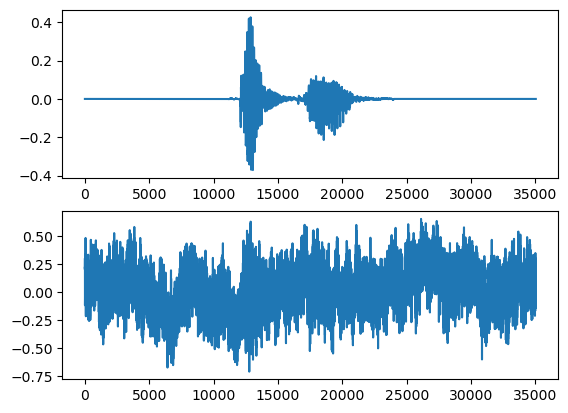

In [56]:
x,sr = add_noise(signal_name,"pink", snr= -3,target_amp= -3)
print(sr)

signal, signal_rate = librosa.load(signal_name)  # for plotting
z = np.zeros(int(signal_rate/2))
signal = np.append(np.append(z,signal),z) #add 500 ms of silence before and after signal

fig, [ax1,ax2] = plt.subplots(2, 1)

ax1.plot(signal)
ax2.plot(x)  # the noise-added signal

ipd.Audio(x,rate=signal_rate)   # put up the audio control object

## Process files -- example usage of add_noise()

Loop through your audio directory and add noise to each file in it, and write resulting mixed audio as .wav files in the same directory.

In [58]:
# read in audio data for each file and mix w/noise at specified snr 
for signal_name in list(signal_home.glob('*.wav')):
    for snr in range(-3,4,3):
        x,sr = add_noise(signal_name, "pink", snr = snr) 

        new_name = (f'{signal_home / signal_name.stem}_pink_snr{snr}.wav')
        print(f'saving {new_name}')
   
        sf.write(new_name, x, sr, subtype='PCM_16')

    
print('finished')


signal peak = 0.13825257806892016
saving /Users/kjohnson/Google Drive/Remirez_experiment/sounds/original/pro_5_pink_snr-3.wav
signal peak = 0.13825257806892016
saving /Users/kjohnson/Google Drive/Remirez_experiment/sounds/original/pro_5_pink_snr0.wav
signal peak = 0.13825257806892016
saving /Users/kjohnson/Google Drive/Remirez_experiment/sounds/original/pro_5_pink_snr3.wav
signal peak = 0.101041604276356
saving /Users/kjohnson/Google Drive/Remirez_experiment/sounds/original/val_2_pink_snr-3.wav
signal peak = 0.101041604276356
saving /Users/kjohnson/Google Drive/Remirez_experiment/sounds/original/val_2_pink_snr0.wav
signal peak = 0.101041604276356
saving /Users/kjohnson/Google Drive/Remirez_experiment/sounds/original/val_2_pink_snr3.wav
signal peak = 0.09661365431041594
saving /Users/kjohnson/Google Drive/Remirez_experiment/sounds/original/val_3_pink_snr-3.wav
signal peak = 0.09661365431041594
saving /Users/kjohnson/Google Drive/Remirez_experiment/sounds/original/val_3_pink_snr0.wav
sig